# Pricing Tool Analysis Code

In [1]:
%load_ext autoreload
%autoreload

#%autoreload
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("""<style>div.output_area{max-height:10000px;overflow:scroll;}</style>"""))

import pandas as pd
pd.set_option("display.max_rows",1000)
pd.set_option("display.max_columns",500)
pd.set_option('precision', 3)

from os.path import join
from os import listdir
from pandas import read_csv, read_excel, Series, DataFrame, to_numeric, read_parquet, to_datetime
from sklearn.externals import joblib

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

from pmdarima.arima import auto_arima

# Load Pricing Tool CSV Files

In [2]:
def loadCSVData():
    from glob import glob
    files = glob("/Users/tgadfort/Downloads/OneDrive_1_5-23-2019/03072019/*/*/*")
    ptdata = [read_csv(x, dtype=str) for x in files]
    print("Found {0} data files".format(len(ptdata)))

    files = glob("/Users/tgadfort/Downloads/OneDrive_1_5-23-2019/05102019/*/*")
    ptdata2 = [read_csv(x, dtype=str) for x in files]
    print("Found {0} data files".format(len(ptdata2)))
    
    from pandas import concat
    ptcombo = concat(ptdata + ptdata2)
    return ptcombo

#ptcombo = loadCSVData()
#ptcombo.to_parquet("Some Parquet File.parquet")

# Load Pricing Tool Data

In [2]:
pfile  = "/Users/tgadfort/Documents/PricingTool/pricing_tool_data.parquet"
print("Loading {0}. This takes a minute".format(pfile))
ptdata = read_parquet(pfile)
print("Pricing Tool Data: {0}".format(ptdata.shape))

Loading /Users/tgadfort/Documents/PricingTool/pricing_tool_data.parquet. This takes a minute


/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Pricing Tool Data: (5081664, 91)


In [ ]:
## Format columns
ptdata['Calendar Day'] = to_datetime(ptdata["Calendar Day"], format='%Y%m%d')
ptdata['Promo Start Date'] = to_datetime(ptdata["Promo End Date"], format='%Y%m%d')

In [6]:
ptdata.describe()

Calendar Day Profit Center Acct Channel - Sold To  \
count       5081664       5081664                4527662   
unique         1942            28                     14   
top        20180201    RAS Pro US             Pro-Dealer   
freq          54474       1921605                1950498   

       Acct SlsGrp - Sold To  Acct SoldT           Acct SoldTo - Desc  \
count                5006820     5058940                      5058940   
unique                    20        6861                         6661   
top      LM National account  0000199983  CONSUMER CREDIT CARD ORDERS   
freq                  705325      396570                       396570   

        Acct ShipT           Acct ShipTo - Desc Geo - City Geo State  \
count      4836723                      4836723    4930701   5081365   
unique       16415                        14079      21987       111   
top     0000199983  CONSUMER CREDIT CARD ORDERS    HOUSTON        CA   
freq        393252                       393252      82379    494196   

       Geo Country Geo - Postal Code Product SBU Product Brand Product Type  \
count      5081663           5081363     4986335       4986336      4986336   
unique          30            173212           9            15           15   
top             US             85621     Pro GDO    LiftMaster  Accessories   
freq       4626064            111922     2010140       3377587      1592017   

       Product Category Product Classificatn Product Family  \
count           4986336              4986336        4986336   
unique               70                   50             88   
top              Common                 Null           Null   
freq            1126934              2385300         817081   

       Product Connectivity Product Options Prod Sub-type/ERA  Product  \
count               4986336         4986336           4986329  5032821   
unique                    5              38                82    10734   
top                    Null            Null              Null    CPS-U   
freq                1960425         2376108           2102826   130244   

                    Product - Desc Product Group 1       Promotion  \
count                      5032821         5032646          293019   
unique                        7389               8             140   
top     COMMERCIAL LOGIC PROTECTOR     Accessories  2018 IDA Promo   
freq                        130244         2547794           21570   

       Promo Start Date Promo End Date Total Sales Qty Total Return Qty  \
count            293019         293019         5081664          5081664   
unique              123            105            2256              483   
top            20180402       20180523           1.000            0.000   
freq              21570          21570         1610572          4808921   

       Total Net Sales Qty List Price Base Price Special Net Price  \
count              5081664    5081664    5081664           5081664   
unique                2458     211800     150164                21   
top                  1.000       0.00       0.00              0.00   
freq               1609411     608556    1443682           5081643   

       Special Final Price Group Condiiton(Brkt Returns Restock Fee  \
count              5081664              5081664             5081664   
unique               21983                48999                  40   
top                   0.00                 0.00                0.00   
freq               4944226              4468877             5081625   

       Modification 1 Variance - Revenue Manual Price  Revenue  \
count         5081664            5081664      5081664  5081664   
unique           3442              35194        21382    17567   
top              0.00               0.00         0.00     0.00   
freq          5057732            4289735      5031915  5047166   

       FG Sales Rev - Manua Access.Rev - Dom Man Parts Revenue (Man)  \
count               5081664              5081664           

In [11]:
ptdata['Calendar Day'] = to_datetime(ptdata["Calendar Day"], format='%Y%m%d')
ptdata.head()


Calendar Day Profit Center Acct Channel - Sold To Acct SlsGrp - Sold To  \
0   2015-05-01        CAS US                   None                  None   
1   2015-05-01        CAS US                   None                  None   
2   2015-05-01        CAS US           Pro-National      US West Mid West   
3   2015-05-01        CAS US           Pro-National      US West Mid West   
4   2015-05-01        CAS US           Pro-National      US West Mid West   

   Acct SoldT              Acct SoldTo - Desc  Acct ShipT  \
0        None                            None        None   
1        None                            None        None   
2  0000166677  RAYNOR DOOR ATHRTY OF ROCKFORD  0000166677   
3  0000166677  RAYNOR DOOR ATHRTY OF ROCKFORD  0000745303   
4  0000166677  RAYNOR DOOR ATHRTY OF ROCKFORD  0000745303   

                  Acct ShipTo - Desc  Geo - City Geo State Geo Country  \
0                               None        None        AZ          US   
1                               None  PLAIN CITY        OH          US   
2     RAYNOR DOOR ATHRTY OF ROCKFORD  LOVES PARK        IL          US   
3  RAYNOR DOOR ATHRTY OF SAUK VALLEY       DIXON        IL          US   
4  RAYNOR DOOR ATHRTY OF SAUK VALLEY       DIXON        IL          US   

  Geo - Postal Code Product SBU Product Brand          Product Type  \
0             85621        None          None                  None   
1        43064-8409        None          None                  None   
2        61111-1943         CDO    LiftMaster  Finishing Components   
3        61021-2703         CDO    LiftMaster             Operators   
4        61021-2703         CDO    LiftMaster           Accessories   

       Product Category Product Classificatn Product Family  \
0                  None                 None           None   
1                  None                 None           None   
2         Trolley Track                 Null           Null   
3  Medium Duty Operator            1/2 HP AC      Jackshaft   
4        Safety Devices                 Null      Photo Eye   

  Product Connectivity       Product Options Prod Sub-type/ERA    Product  \
0                 None                  None              None       None   
1                 None                  None              None       None   
2                 Null                  Null              Null  10-5816-P   
3        Not Connected          Non-Modified              Null    MJ5011U   
4                 Null  Monitored Entrapment      Through Beam      CPS-U   

                         Product - Desc Product Group 1       Promotion  \
0                                  None            None            None   
1                                  None            None            None   
2  TRACKTROLLEYFOR 16FT DOORPRE-PUNCHED     Accessories            None   
3        1/2HP 115V 1P 60Hz MEDIUM DUTY    Finish Goods  IDA PROMO 2015   
4            COMMERCIAL LOGIC PROTECTOR     Accessories            None   

  Promo Start Date Promo End Date Total Sales Qty Total Return Qty  \
0             None           None           0.000            0.000   
1             None           None           0.000            0.000   
2             None           None           0.000           1.000-   
3         20150326       20150522           4.000            0.000   
4             None           None           4.000            0.000   

  Total Net Sales Qty List Price Base Price Special Net Price  \
0               0.000       0.00       0.00              0.00   
1               0.000       0.00       0.00              0.00   
2              1.000-       0.00       0.00              0.00   
3               4.000    2892.00    2892.00              0.00   
4               4.000       0.04       0.04              0.00   

  Special Final Price Group Condiiton(Brkt Returns Restock Fee Modification 1  \
0                0.00                 0.00                0.00           0.00   
1                0.00            

In [73]:
def fixValue(x):
    if x is None:
        return None
    
    if x.endswith('-'):
        try:
            value = -1*float(x[:-1])
        except:
            value = None
    else:
        try:
            value = float(x)
        except:
            value = None
            
    return value

#fixCols = ["Total Sales Qty", "Total Return Qty", "Total Net Sales Qty", "List Price", "Base Price", "Special Net Price", "Special Final Price", "Group Condiiton(Brkt", "Returns Restock Fee", "Modification 1", "Variance - Revenue", "Manual Price", "Revenue", "FG Sales Rev - Manua", "Access.Rev - Dom Man", "Parts Revenue (Man)", "Contract Progr - Prc", "Multiplier Discounts", "Discount Bfr Gross", "Cust Multplr Manual", "Variance - Discount", "BOM Discount", "Parts Program Disc", "Gross Sales", "Discounts & Allowanc", "Cust Specific Disc", "Header Discount", "Volume Discount (Qua", "Customer Promotions", "Item Discount", "Promo&Coupons in %", "100% Discount", "Sales Discount", "Credit/Debit Memos", "Manual discret.Disc.", "Invoice Sales", "Other Discounts", "Cust Fines Manual", "Customer Fines", "Cash Discount", "Total Freight", "Drop Ship Fee %", "Drop Ship Fee Abs", "Drop Ship Discount", "Freight Discount", "Consumer FreightBase", "Prepaid & Add Frght", "Drp Shp Dis Wrt Off", "Returns", "Rebates", "Manual FI Rebate", "Mat/Group Rebate", "Material Rebate", "Sales Indpndt Rebate", "Consumer Rebates", "Other Revenue", "SalesRev - Serv (Man", "Software Rev (Man)", "Deferred Revenue", "Deferred Rev Recog", "Service Revenue", "Net Sales", "Total COGS Standard", "Gross Profit Standard"]
fixCols = []
for col in fixCols:
    if ptdata[col].dtype == 'object':
        print(col)
        try:
            tmp = ptdata[col].apply(float)
        except:
            print("\tCalling fixValue()")
            tmp = ptdata[col].apply(fixValue)
        ptdata[col] = tmp


In [47]:
dbg  = ptdata["Discount Bfr Gross"]
negs = dbg.str.endswith('-')
#dbg[dbg.str.endswith('-')].str.
vals = dbg.str.split('-').str.get(0)
vals = vals.apply(float)

In [43]:
vals[negs] = vals[negs].apply(lambda x: x*-1)

In [48]:
vals.describe()

count    5.082e+06
mean     3.362e+02
std      1.872e+03
min      0.000e+00
25%      0.000e+00
50%      0.000e+00
75%      7.880e+01
max      3.879e+05
Name: Discount Bfr Gross, dtype: float64

In [50]:
vals[negs] = vals[negs].apply(lambda x: x*-1)

In [51]:
vals

0            0.00
1            0.00
2            0.00
3        -1677.36
4            0.00
5            0.00
6         -250.88
7         -343.75
8          -41.42
9         -420.00
10        -277.77
11       -1178.12
12        -956.25
13       -3540.00
14        -760.62
15        -760.62
16           0.00
17        -125.00
18           0.00
19           0.00
20           0.00
21           0.00
22         -19.32
23        -560.04
24         -16.67
25        -969.44
26         -98.32
27           0.00
28           0.00
29         -14.37
30         -27.38
31          -1.97
32         -64.40
33         -14.00
34         -10.62
35        -280.02
36        -171.34
37       -1010.84
38           0.00
39        -159.52
40         -23.00
41         -53.56
42         -32.48
43        -336.00
44        -425.60
45       -1422.40
46           0.00
47         -48.16
48         -48.16
49         -59.36
50         -16.24
51         -17.92
52           0.00
53           0.00
54           0.00
55        

In [2]:
dateStart = "1/1/2014"
def getDates(dateStart, periods):
    dateInfo = [x.to_pydatetime().strftime("%b, %Y") for x in date_range(start=dateStart, periods=periods, freq='M')]
    return dateInfo

In [113]:
def getBestFit(df, m=12):
    stepwise_fit = auto_arima(df.value, start_p=1, start_q=1, max_p=3, max_q=3, m=m,
                              start_P=0, seasonal=True, d=1, D=1, trace=True,
                              error_action='ignore',  # don't want to know if an order does not work
                              suppress_warnings=True,  # don't want convergence warnings
                              stepwise=True)  # set to stepwise

    return stepwise_fit

In [96]:
def getSARIMAX(df, steps, order, seasonal_order):
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    # 1,1,2 ARIMA Model
    model = SARIMAX(df.value, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    fit_res = model.fit(disp=False)
    res = model.filter(fit_res.params)

    # Perform prediction and forecasting
    predict = res.get_prediction()
    forecast = res.get_forecast(steps)

    # Get central and CI values
    forecasts = {}
    for cl in [0.5, 0.9, 0.68, 0.95]:
        forecast_mean = forecast.predicted_mean
        forecast_cint = forecast.conf_int(alpha=1-cl)
        forecasts[cl] = [forecast_mean, forecast_cint]

    cl=0.9
    predict_mean = predict.predicted_mean
    predict_mean = predict_mean[2:]
    predict_cint = predict.conf_int(alpha=1-cl)
    predict_cint = predict_cint[2:]
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from numpy import sqrt
    ytrue = df.value[2:]
    ypred = predict_mean
    mae  = mean_absolute_error(ytrue, ypred)
    rmse = sqrt(mean_squared_error(ytrue, ypred))
    

    return [predict_mean, predict_cint, forecasts, mae, rmse]

In [104]:
def getARIMA(df, steps, order):
    from statsmodels.tsa.arima_model import ARIMA
    from pandas import concat

    # 1,1,2 ARIMA Model
    model = ARIMA(df.value, order=order)
    res = model.fit(disp=False)
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from numpy import sqrt, arange
    ytrue = len(res.resid)*[0]
    ypred = res.resid
    mae  = mean_absolute_error(ytrue, ypred)
    rmse = sqrt(mean_squared_error(ytrue, ypred))

    # Get central and CI values
    predict_mean = df["value"][2:] + res.resid[1:]
    cl = 0.9
    predict_cint = concat([Series(predict_mean - res.conf_int(alpha=1-cl).values[0][0]), 
                           Series(predict_mean + res.conf_int(alpha=1-cl).values[0][1])], axis=1)
    predict_cint.columns = ["lower value", "upper value"]

    forecasts = {}
    for cl in [0.5, 0.9, 0.68, 0.95]:
        fc1, se1, conf1 = res.forecast(steps, alpha=1-cl)
        forecast_index = arange(len(df.values), len(df.values)+steps)
        forecast_mean = Series(fc1)
        forecast_mean.index = forecast_index
        forecast_cint = DataFrame(conf1)
        forecast_cint.columns = ["lower value", "upper value"]
        forecast_cint.index = forecast_index
        forecasts[cl] = [forecast_mean, forecast_cint]
        
    return [predict_mean, predict_cint, forecasts, mae, rmse]

In [105]:
def plotForecast(df, ftype, tsdata, title):
    fig, ax = plt.subplots(figsize=(12,5))
    
    from sklearn.metrics import mean_squared_error
    
    predict_mean = tsdata[0]
    predict_cint = tsdata[1]
    forecasts    = tsdata[2]
    
    mae  = tsdata[3]
    rmse = tsdata[4]

    # Plot the results
    df.value.plot(ax=ax, style='k.', label='Observations')
    predict_mean.plot(ax=ax, label='Insample Prediction\nMAE = {0} , RMSE = {1}'.format(round(mae,2),round(rmse,2)))
    ax.fill_between(predict_cint.index, predict_cint.iloc[:, 0], predict_cint.iloc[:, 1], alpha=0.1)

    cls  = [0.95, 0.68]
    cls  = [0.9, 0.5]
    cols = ['green', 'yellow']

    if ftype == "ARIMA(0,1,0)":
        ftype = "{0} (Random Walk)".format(ftype)
    elif ftype == "ARIMA(0,0,0)":
        ftype = "{0} (Noise)".format(ftype)
    elif ftype == "ARIMA(0,1,2)":
        ftype = "{0} (Damped Holt)".format(ftype)
    elif ftype == "ARIMA(0,1,1)":
        ftype = "{0} (Exp Smoothing)".format(ftype)
    elif ftype == "ARIMA(0,2,2)":
        ftype = "{0} (Double Exp Smoothing)".format(ftype)
        
    from numpy import sqrt

    forecasts[cls[0]][0].plot(ax=ax, style='black', label='{0} Forecast'.format(ftype))
    for cl,col in dict(zip(cls,cols)).items():
        forecast_cint = forecasts[cl][1]

        forecast_sigma = sqrt(max(mean_squared_error(forecasts[cl][0], forecast_cint.iloc[:, 0]), 
                                  mean_squared_error(forecasts[cl][0], forecast_cint.iloc[:, 1])))

        ax.fill_between(forecast_cint.index, forecast_cint.iloc[:, 0], forecast_cint.iloc[:, 1], 
                        alpha=0.55, color=col, label="{0}% CL  ({1})".format(int(100*cl), round(forecast_sigma, 2)))

    left, right = plt.xlim()
    plt.xlim(left-2, right+2)
    
    down, up = plt.ylim()
    plt.ylim(down/1.1, up*1.2)


        
    locs, labels = plt.xticks()
    
    histlen = len(df.value)
    forelen = len(forecasts[cls[0]][0])
    
    from numpy import arange
    locs = list(range(6-1, histlen+forelen-1, 6))
    locs = [0] + locs + [histlen+forelen-1]
    #locs.insert(0, 0)
    #print(locs)
    #locs = arange(0, 62+22+1, step=6)
    #print(locs)
    dates = getDates(dateStart, periods=histlen+forelen+1)
    xlabels = [dates[int(x)] for x in locs]
    plt.xticks(locs, xlabels, rotation=90)
    
    
    #plt.xticks(np.arange(12), calendar.month_name[1:13], rotation=20)        

    plt.title(title)
    plt.xlabel("Time [Months]")
    plt.ylabel("Sales [$]")
    plt.legend(loc='upper left', fontsize=9)
    plt.show()

# Load Pricing Tool Output Data

In [6]:
onedir = "/Users/tgadfort/OneDrive - The Chamberlain Group, Inc/"

In [7]:
codedir = join(onedir, "Pricing Tool Code & Data")
datadir = join(onedir, codedir, "input")
inputdir = join(datadir, "full")
outputdir = join(onedir, codedir, "output/Archive")

In [8]:
files = ['growth_multiplier_prep.csv', 'base_multiplier.csv', 'growth_multiplier.csv']
basefile = join(outputdir, files[1])

In [ ]:
bmpdf = read_csv(basefile)

In [ ]:
compdata = bmpdf[bmpdf["acct_soldto"] == 101933]

In [ ]:
#compdata.T

# Load Pricing Tool Input Data

In [100]:
raspdf = read_csv(join(inputdir, "ras.csv"), header=None)
from pandas import date_range
#cols = ["Account"] + ["{0}_{1}".format(x.year, x.month) for x in date_range(start="1/1/2014", periods=62, freq='M')] + ["Description", "ListSales2018"]
cols = ["Account"] + getDates(dateStart, 62) + ["Description", "ListSales2018"]
raspdf.columns = cols
raspdf.index = raspdf["Account"]
raspdf.drop(["Account"], axis=1, inplace=True)

caspdf = read_csv(join(inputdir, "cas.csv"), header=None)
from pandas import date_range
#cols = ["Account"] + ["{0}_{1}".format(x.year, x.month) for x in date_range(start="1/1/2014", periods=62, freq='M')] + ["Description", "ListSales2018"]
cols = ["Account"] + getDates(dateStart, 62) + ["Description", "ListSales2018"]
caspdf.columns = cols
caspdf.index = caspdf["Account"]
caspdf.drop(["Account"], axis=1, inplace=True)

paspdf = read_csv(join(inputdir, "pas.csv"), header=None)
from pandas import date_range
#cols = ["Account"] + ["{0}_{1}".format(x.year, x.month) for x in date_range(start="1/1/2014", periods=62, freq='M')] + ["Description", "ListSales2018"]
cols = ["Account"] + getDates(dateStart, 62) + ["Description", "ListSales2018"]
paspdf.columns = cols
paspdf.index = paspdf["Account"]
paspdf.drop(["Account"], axis=1, inplace=True)

In [80]:
rasaccount = raspdf.sum(axis=1).sort_values(ascending=False).index[2]
casaccount = caspdf.sum(axis=1).sort_values(ascending=False).index[2]
pasaccount = paspdf.sum(axis=1).sort_values(ascending=False).index[2]

rasaccdata = to_numeric(raspdf.loc[rasaccount].drop(["Description", "ListSales2018"]))
casaccdata = to_numeric(caspdf.loc[casaccount].drop(["Description", "ListSales2018"]))
pasaccdata = to_numeric(paspdf.loc[pasaccount].drop(["Description", "ListSales2018"]))

rasaccdata = DataFrame(rasaccdata)
rasaccdata.columns = ["value"]
rasaccdata.index = range(len(rasaccdata.index))

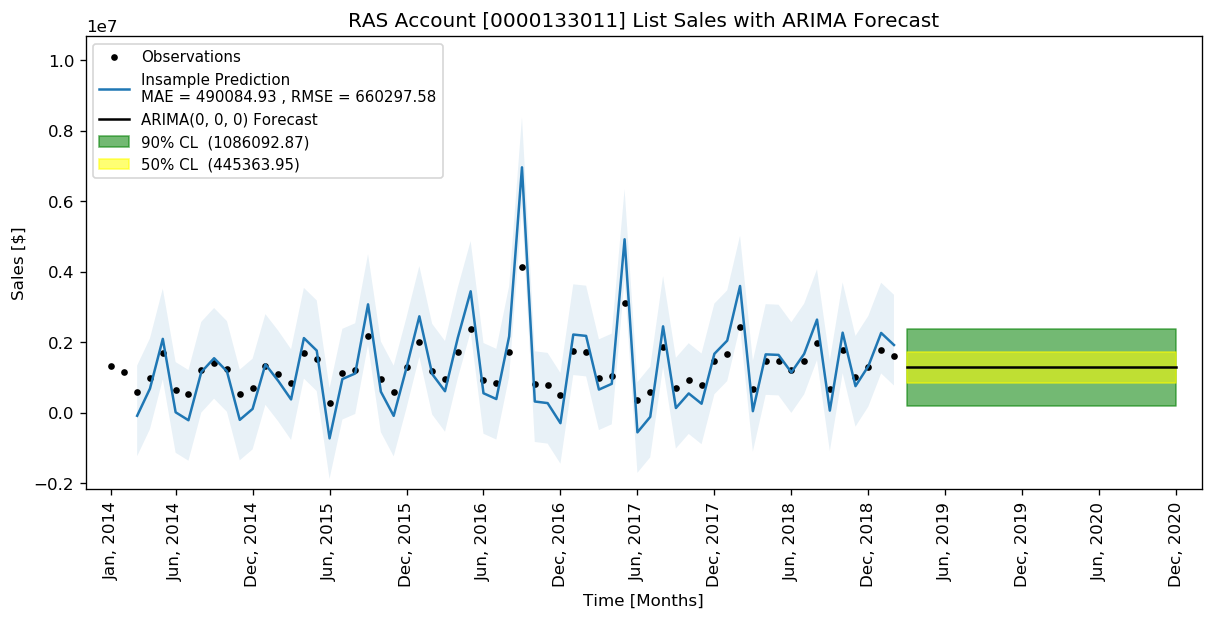

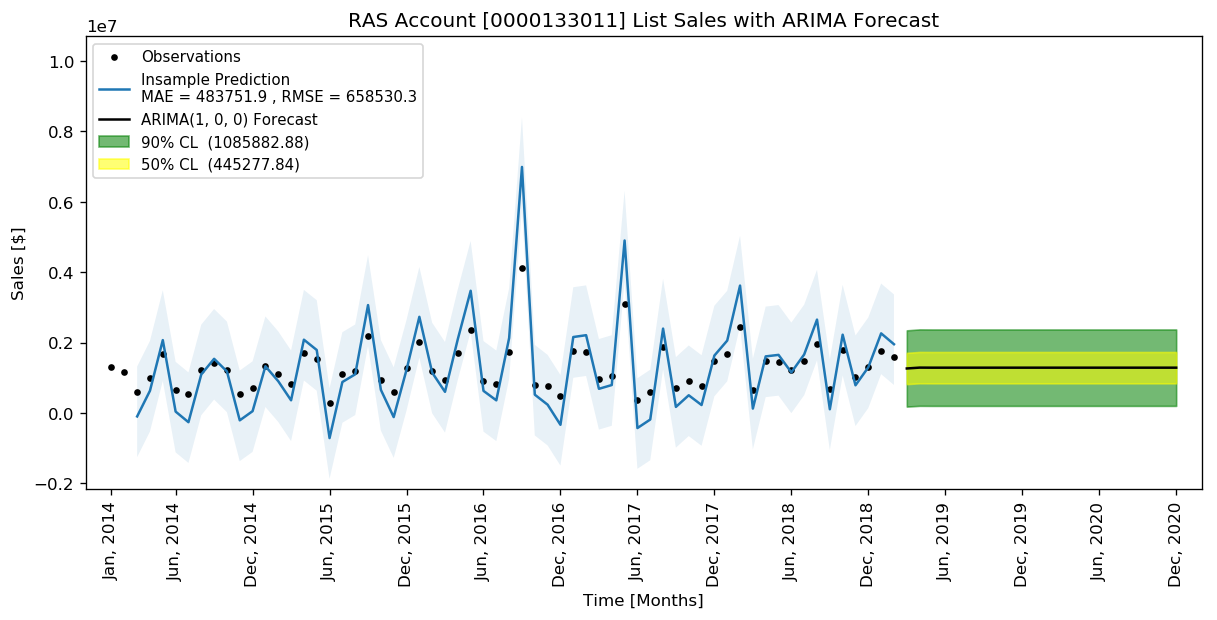

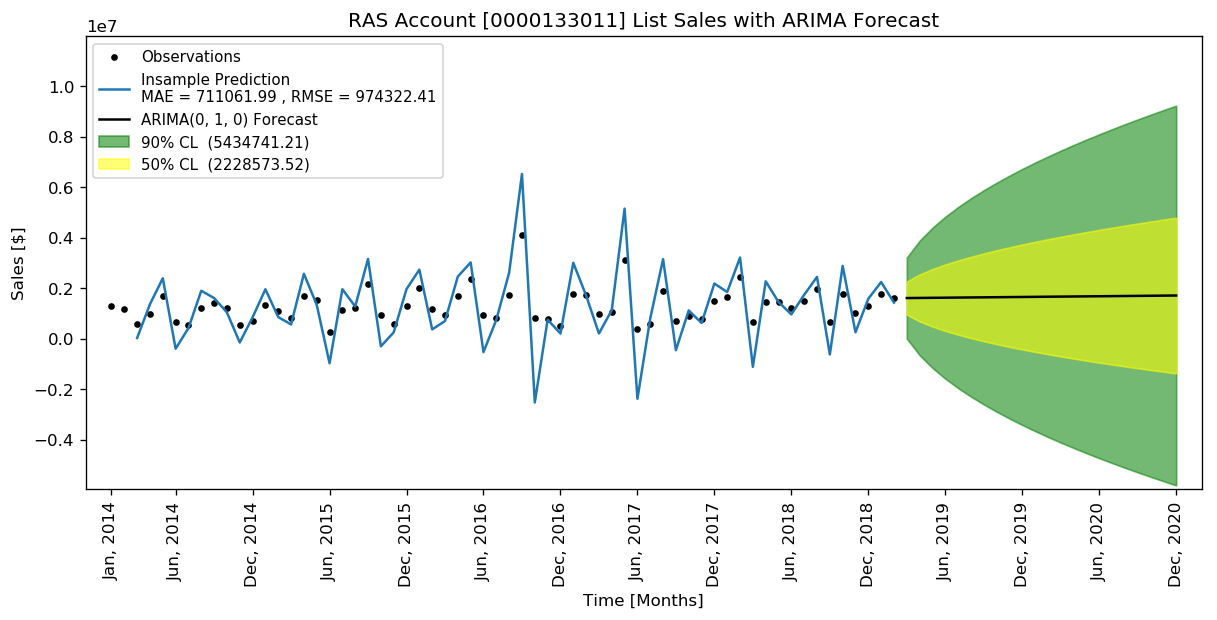

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


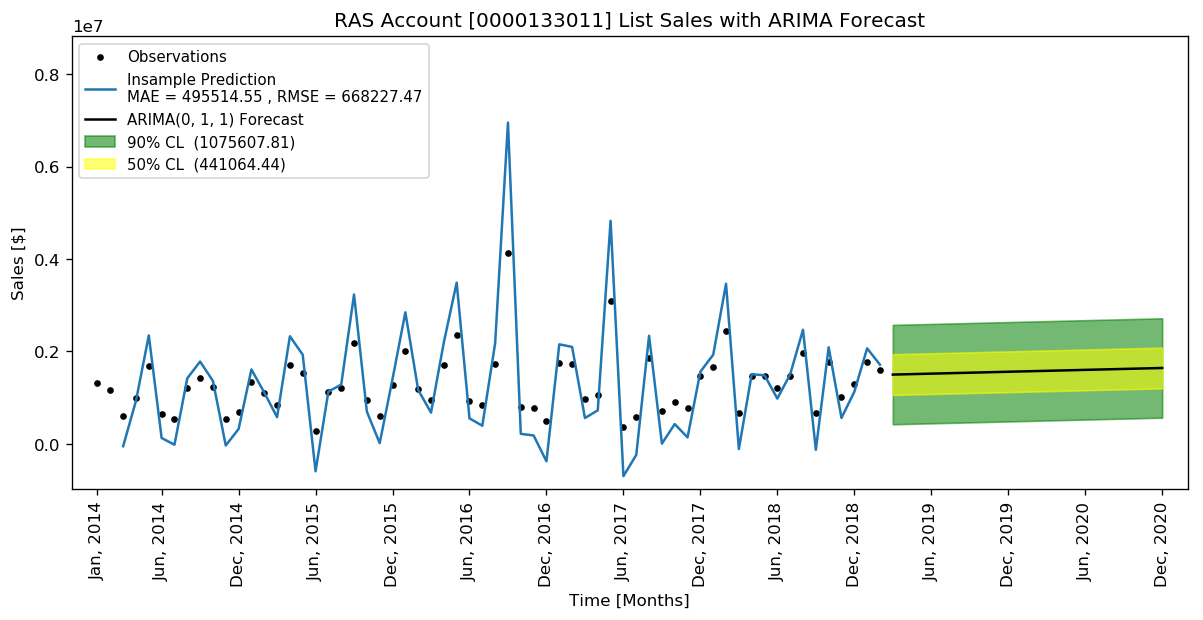

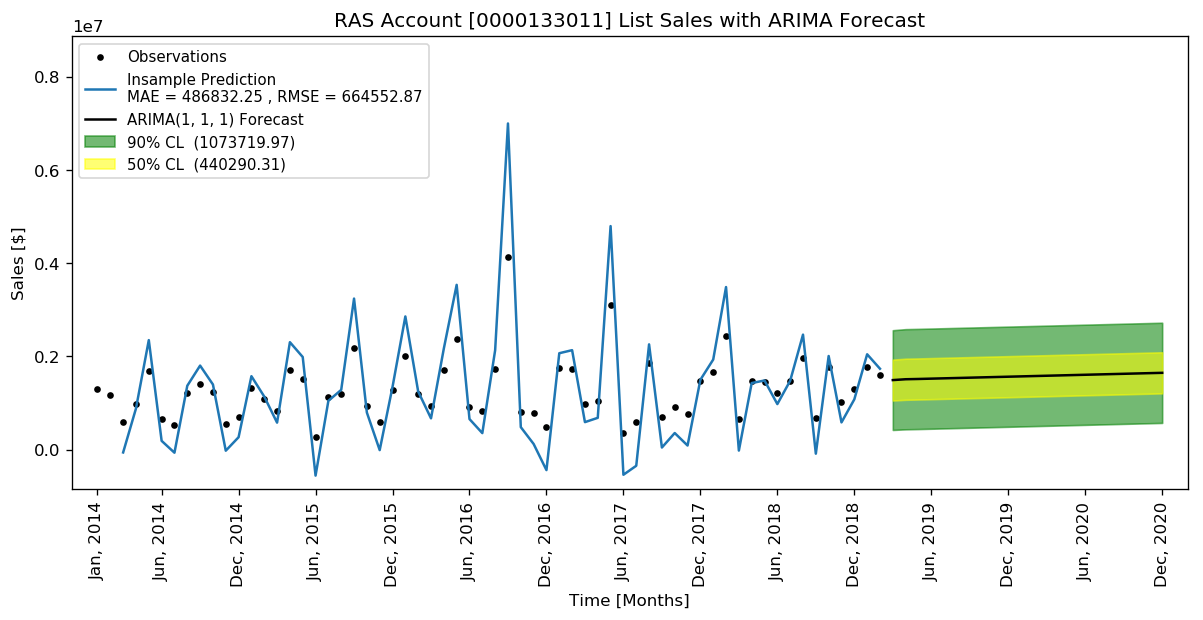

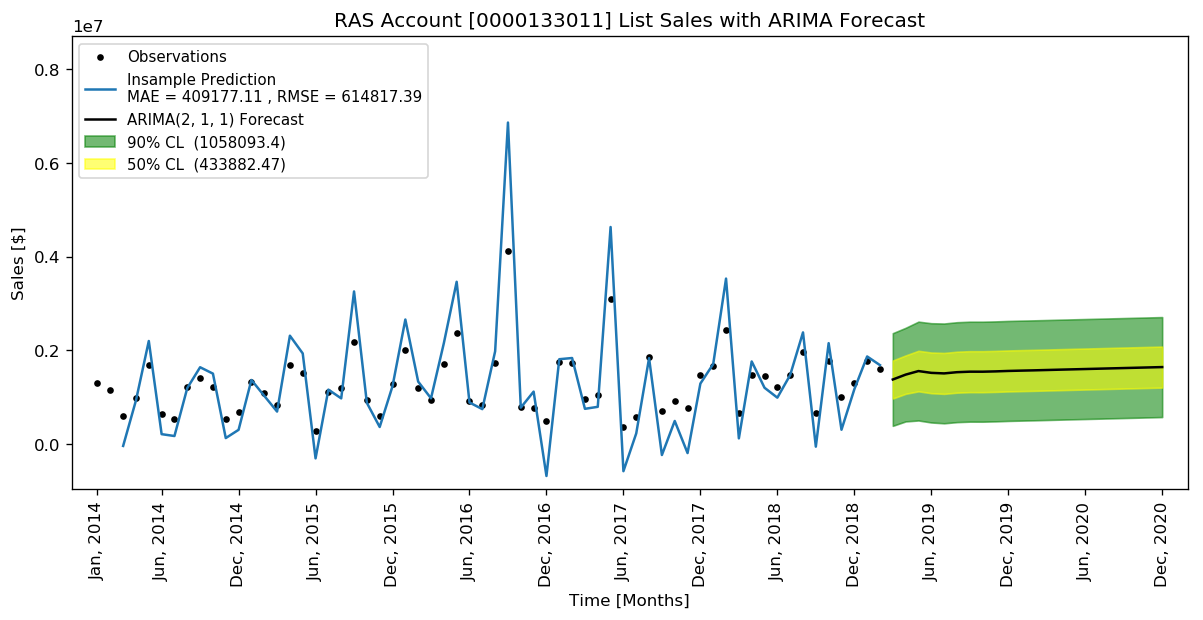

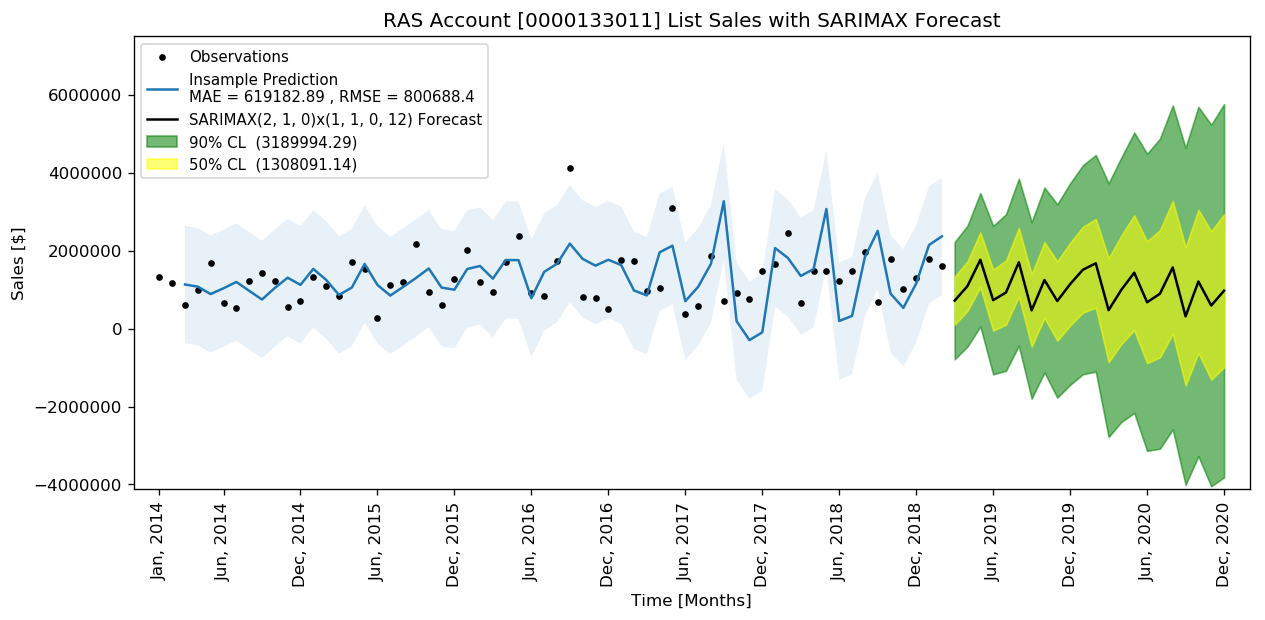

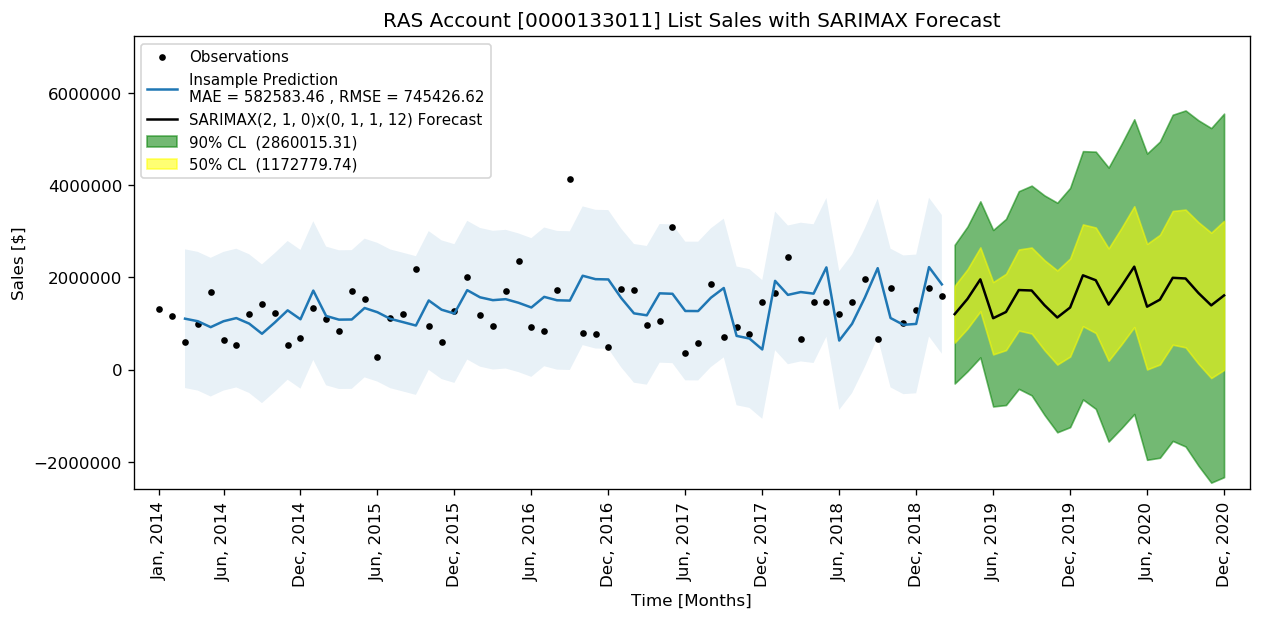

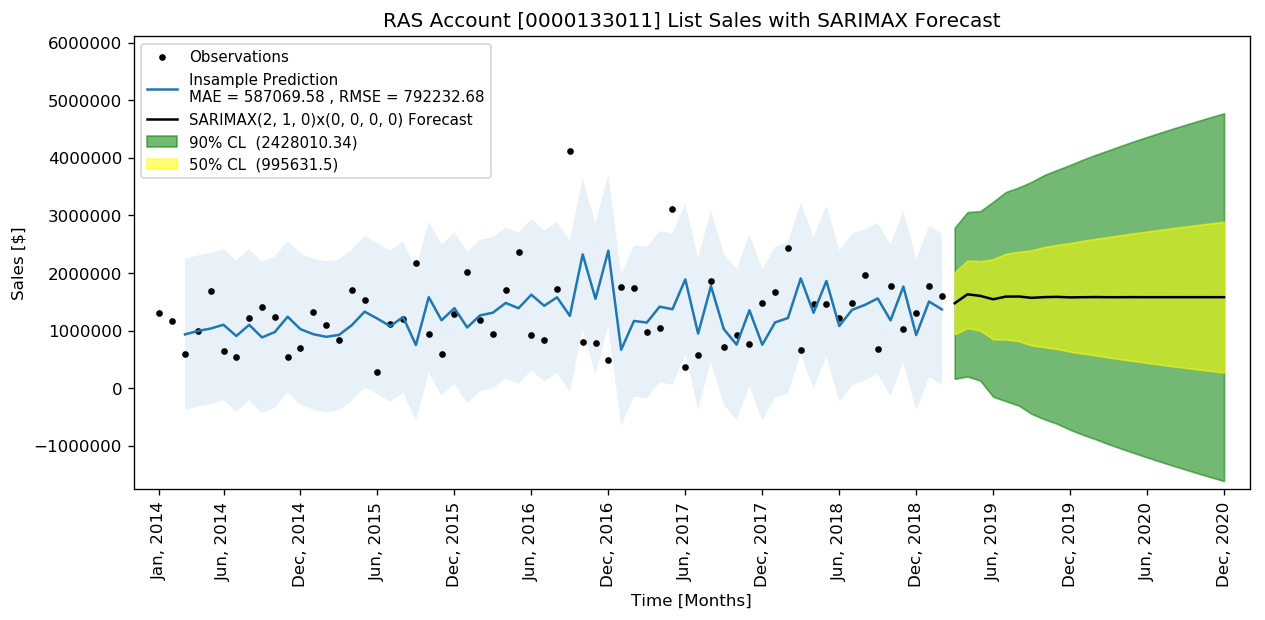

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1859.429, BIC=1863.651, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1851.699, BIC=1858.032, Fit time=0.016 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1822.307, BIC=1828.640, Fit time=0.018 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.048 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


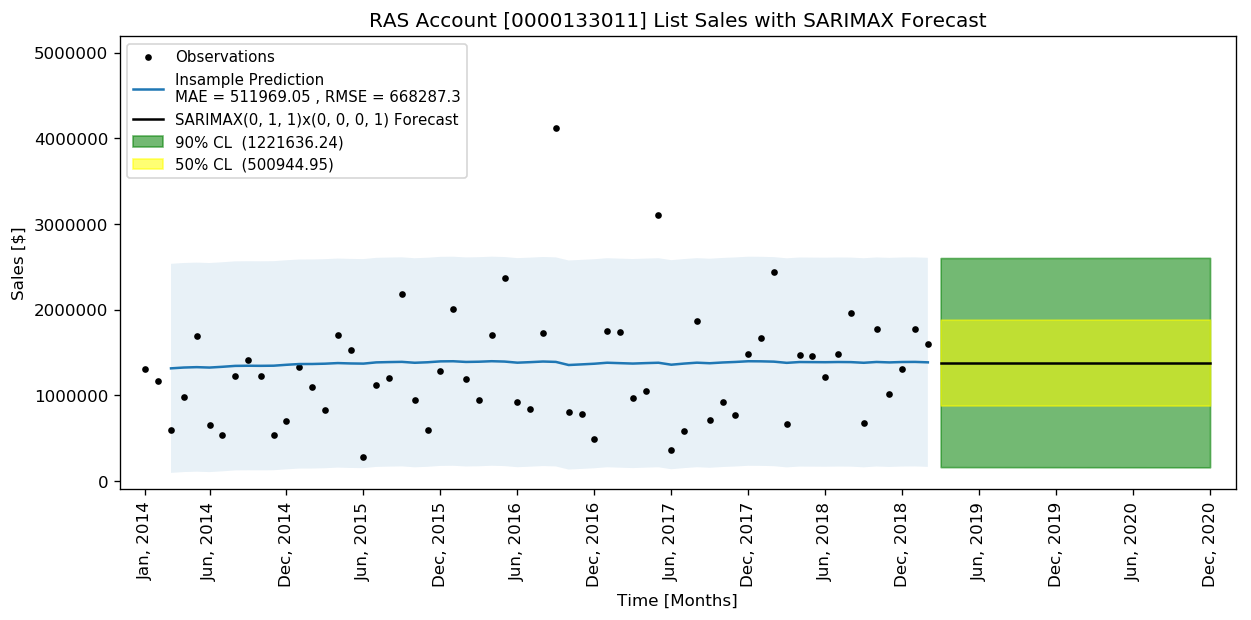

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 3); AIC=1811.323, BIC=1815.444, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 3); AIC=1796.846, BIC=1805.088, Fit time=0.029 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 3); AIC=1767.855, BIC=1776.097, Fit time=0.029 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 3); AIC=1769.234, BIC=1779.536, Fit time=0.042 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 3); AIC=1779.168, BIC=1785.350, Fit time=0.025 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 3); AIC=1769.346, BIC=1779.648, Fit time=0.040 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 3); AIC=1769.622, BIC=1781.985, Fit time=0.215 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 3); AIC=1787.696, BIC=1793.877, Fit time=0.017 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


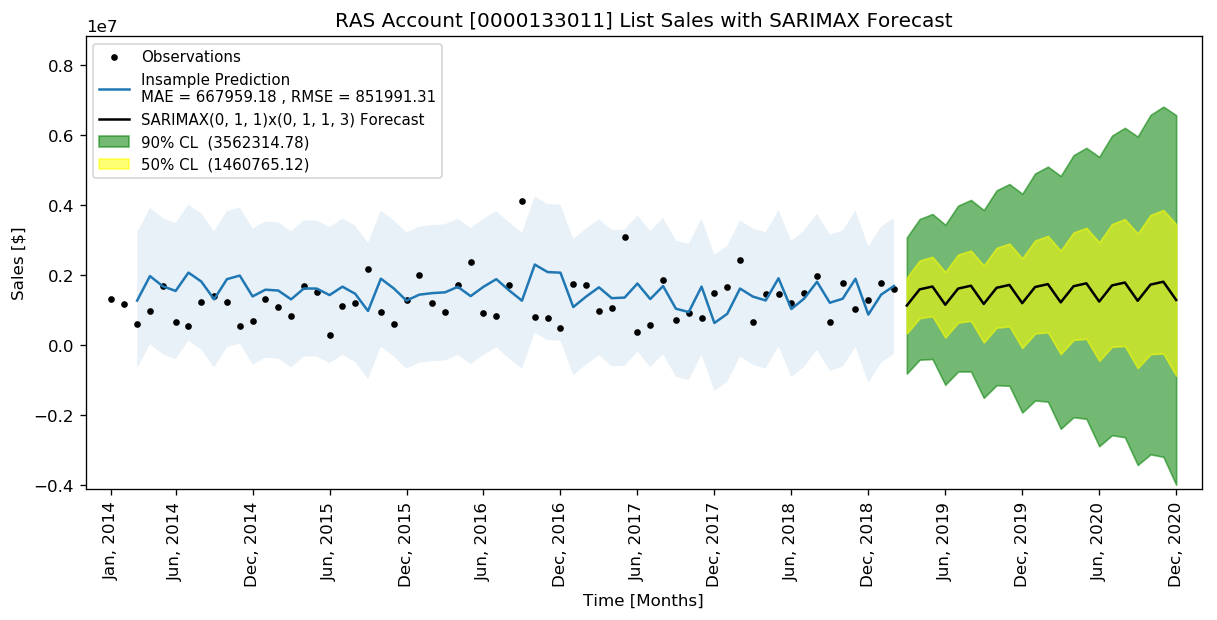

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=1722.026, BIC=1726.041, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=1689.191, BIC=1697.221, Fit time=0.043 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=1676.896, BIC=1684.925, Fit time=0.292 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 6); AIC=1674.193, BIC=1684.229, Fit time=0.059 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 6); AIC=1672.235, BIC=1680.264, Fit time=0.031 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 6); AIC=1676.182, BIC=1688.226, Fit time=0.119 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 6); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=1694.646, BIC=1700.668, Fit time=0.019 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 6); AIC=1

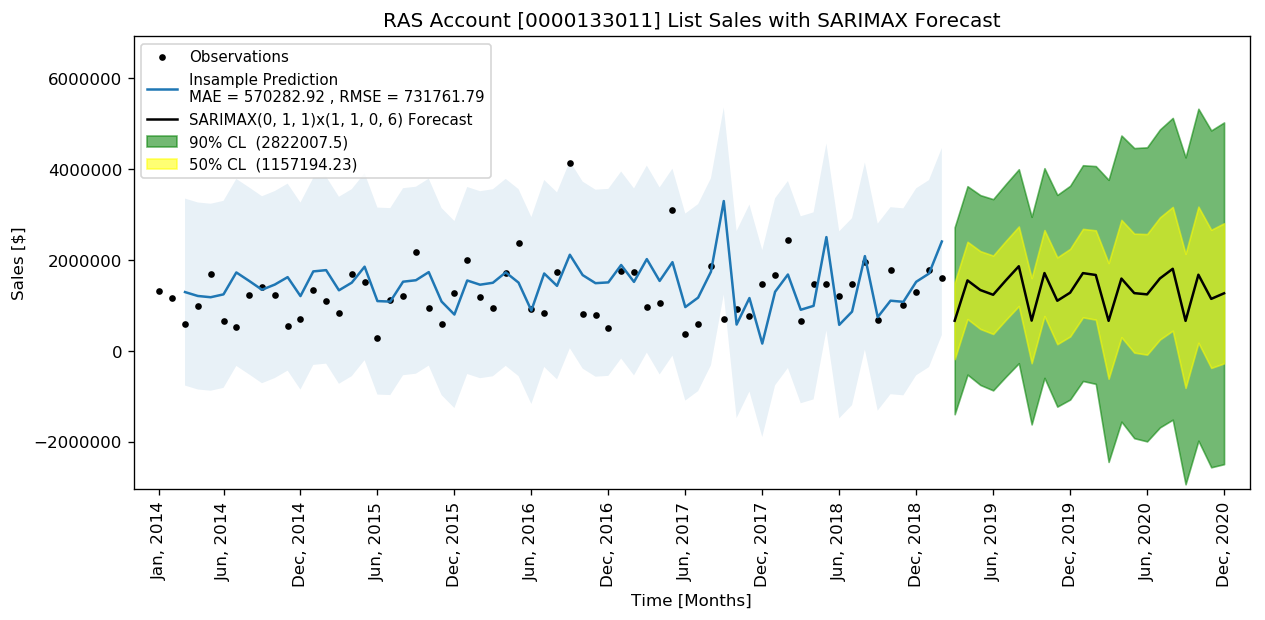

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1509.242, BIC=1513.026, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1491.613, BIC=1499.181, Fit time=0.039 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1493.797, BIC=1499.472, Fit time=0.018 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1507.240, BIC=1512.916, Fit time=0.030 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1487.841, BIC=1497.300, Fit

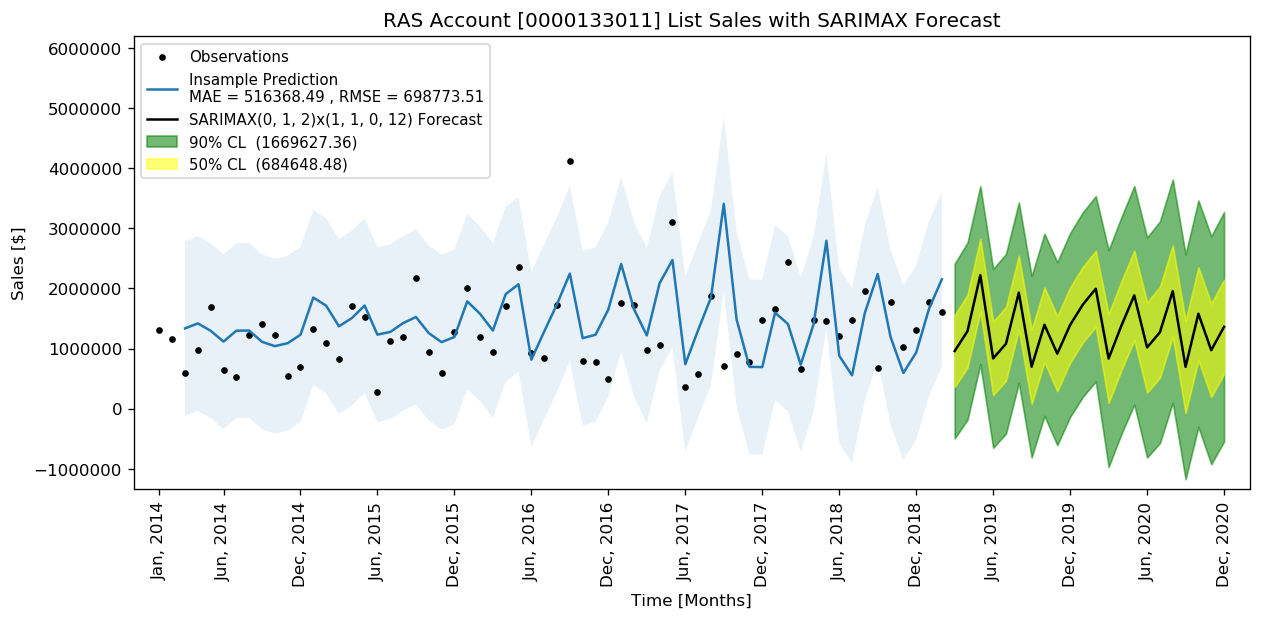

In [114]:
orders=[(0,0,0), (1,0,0), (0,1,0), (0,1,1), (1,1,1), (0,2,2), (2,1,1)]
for order in orders:
    try:
        data = getARIMA(rasaccdata, steps=22, order=order)
    except:
        continue
    plotForecast(rasaccdata, "ARIMA{0}".format(order), data, "RAS Account [{0}] List Sales with ARIMA Forecast".format(rasaccount))
    
orders=[(2,1,0)]#, (1,0,0), (0,1,0), (0,1,1), (1,1,1), (0,2,2), (2,1,1)]
seasonal_orders=[(1, 1, 0, 12), (0, 1, 1, 12), (0,0,0,0)]
for order in orders:
    for seasonal_order in seasonal_orders:
        data = getSARIMAX(rasaccdata, steps=22, order=order, seasonal_order=seasonal_order)
        plotForecast(rasaccdata, "SARIMAX{0}x{1}".format(order,seasonal_order), data, "RAS Account [{0}] List Sales with SARIMAX Forecast".format(rasaccount))

        
ms=[1,3,6,12]
for m in ms:
    result = getBestFit(rasaccdata, m=m)
    order  = result.order
    seasonal_order = result.seasonal_order
    data = getSARIMAX(rasaccdata, steps=22, order=order, seasonal_order=seasonal_order)
    plotForecast(rasaccdata, "SARIMAX{0}x{1}".format(order,seasonal_order), data, "RAS Account [{0}] List Sales with SARIMAX Forecast".format(rasaccount))

(1, 1, 0, 12)

# Fit Time Series

In [ ]:



totdata = raspdf.drop(["Description", "ListSales2018"], axis=1)
rasdf   = DataFrame(totdata.sum())
rasdf.columns = ["value"]
rasdf.index = range(len(rasdf.index))


totdata = caspdf.drop(["Description", "ListSales2018"], axis=1)
casdf   = DataFrame(totdata.sum())
casdf.columns = ["value"]
casdf.index = range(len(casdf.index))

totdata = paspdf.drop(["Description", "ListSales2018"], axis=1)
pasdf   = DataFrame(totdata.sum())
pasdf.columns = ["value"]
pasdf.index = range(len(pasdf.index))

## RAS Fit

In [101]:
getBestFit(rasdf)

NameError: name 'rasdf' is not defined

In [ ]:
order=(2,1,0)
seasonal_order=(1, 1, 0, 12)
sarimadata = getSARIMAX(rasdf, steps=22, order=order, seasonal_order=seasonal_order)
plotForecast(rasdf, "SARIMAX{0}{1}".format(order, seasonal_order), sarimadata, "Total RAS List Sales with SARIMAX Forecast")

## CAS Fit

In [ ]:
getBestFit(casdf)

In [ ]:
order=(0,1,0)
seasonal_order=(0, 1, 1, 12)
sarimadata = getSARIMAX(casdf, steps=22, order=order, seasonal_order=seasonal_order)
plotForecast(casdf, "SARIMAX{0}{1}".format(order, seasonal_order), sarimadata, "Total CAS List Sales with SARIMAX Forecast")

## PAS Fit

In [ ]:
getBestFit(pasdf)

In [ ]:
order=(1,1,2)
seasonal_order=(0, 1, 1, 12)
sarimadata = getSARIMAX(pasdf, steps=22, order=order, seasonal_order=seasonal_order)
plotForecast(pasdf, "SARIMAX{0}{1}".format(order, seasonal_order), sarimadata, "Total PAS List Sales with SARIMAX Forecast")

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Create Dummy Data

In [68]:
ptdata["Profit Center"].value_counts()

RAS Pro US                     1921605
CAS US                         1258193
PAS US                          738909
RAS Retail US                   617749
RAS Retail CA                   135837
RAS Pro CA                      132301
CAS Canada                       99193
RAS Retail - Craftsman US        64762
PAS Canada                       53365
RAS Pro LA                       21741
PAS Latin America                11172
CAS Latin America                 9342
Project Pivot US                  6997
RAS Retail Craftsman CA           5001
RAS Retail LA                     2175
RAS Retail THD US                 1570
Craftsman SBD - US                 457
RAS Retail THD CA                  426
RAS Retail Menards US              339
RAS Retail Craftsman LA            275
Craftsmane SBD - Canada            104
Project Pivot Canada                76
Project Pivot Latin America         44
RAS Retail Merik US                 20
RAS Professional                     4
PAS Dealer US            

In [71]:
number_of_chunks = 10
for i, df_i in  enumerate(np.array_split(ptdata, number_of_chunks)):
    print(i,df_i.shape)
    df_i.to_csv('pricing_tool_data_{0}.csv'.format(i))

0 (508167, 91)
1 (508167, 91)
2 (508167, 91)
3 (508167, 91)
4 (508166, 91)
5 (508166, 91)
6 (508166, 91)
7 (508166, 91)
8 (508166, 91)
9 (508166, 91)


In [6]:
ptdata["Acct Channel - Sold To"].value_counts()

Pro-Dealer              1950498
Pro-National             930635
Pro-Distributor          859356
Ret-Big/Box Home Ctr     335980
Ret-Discounters          204521
Ret-Distributors          81153
Ret-Warehouse Clubs       67292
Ret-Co-Ops                41435
Ret-Electronics Spe       30913
Internal                  16567
Ret-Specialties            4850
Consumer Chamberlain       2402
Pro-End User               2044
International                16
Name: Acct Channel - Sold To, dtype: int64

In [9]:
distdata = ptdata[ptdata["Acct Channel - Sold To"] == "Pro-Distributor"]

In [10]:
dealdata = ptdata[ptdata["Acct Channel - Sold To"] == "Pro-Dealer"]

In [12]:
realdata = ptdata[ptdata["Acct Channel - Sold To"] == "Ret-Distributors"]

In [11]:
distdata.shape

(859356, 91)

In [13]:
dealdata.shape

(1950498, 91)

In [14]:
realdata.shape

(81153, 91)

In [21]:
top10distdata = distdata[distdata["Acct SoldT"].isin(distdata["Acct SoldT"].value_counts()[:10].index)]

In [28]:
for pc,pcdata in top10distdata.groupby("Profit Center"):
    print(pc,pcdata.shape)

CAS Canada (6, 91)
CAS US (86068, 91)
PAS Canada (5, 91)
PAS Dealer US (1, 91)
PAS US (126222, 91)
Project Pivot US (678, 91)
RAS Pro CA (122, 91)
RAS Pro US (77162, 91)
RAS Retail - Craftsman US (131, 91)
RAS Retail US (821, 91)


In [30]:
rcpdata = top10distdata[top10distdata["Profit Center"].isin(["PAS US", "CAS US", "RAS Pro US"])]

In [36]:
copydata = {}
for pc,pcdata in top10distdata.groupby("Profit Center"):
    if pc.endswith("US") == False or "Dealer" in pc or "Pivot" in pc or "Retail" in pc:
        continue
    copydata[pc] = {}
    for acc,accdata in pcdata.groupby("Acct SoldT"):
        copydata[pc][acc] = accdata.head(1)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

In [45]:
months = ["0{0}".format(x) for x in list(range(1,10))] + ["{0}".format(x) for x in range(10,13)]

In [46]:
years = ["{0}".format(x) for x in range(2015,2020)]

In [62]:
datevals = []
for year in years:
    for month in months:
        dateval = "{0}{1}01".format(year,month)
        if year == '2019' and month == '06':
            break
        datevals.append(dateval)

In [63]:
pseudodata = []
for pc,pcdata in copydata.items():
    for acc,accdata in pcdata.items():
        row = accdata.iloc[0]
        for dateval in datevals:
            drow = row.copy()
            drow["Calendar Day"] = dateval
            pseudodata.append(drow)
        
pseudodata = DataFrame(pseudodata)
pseudodata.reset_index(inplace=True, drop=True)
pseudodata = pseudodata.sample(frac=1)
pseudodata.reset_index(inplace=True, drop=True)

In [66]:
pseudodata["Profit Center"].value_counts()

PAS US        530
CAS US        530
RAS Pro US    530
Name: Profit Center, dtype: int64

In [65]:
pseudodata["Acct SoldT"].value_counts()

0000195035    159
0000133011    159
0000103036    159
0000156463    159
0000115749    159
0000109183    159
0000166131    159
0000106783    159
0000100745    159
0000164110    159
Name: Acct SoldT, dtype: int64

In [74]:
col = "Invoice Sales"
pseudodata["IS"] = pseudodata[col].apply(fixValue)

In [82]:
import numpy as np
for lob,lobdata in pseudodata.groupby("Profit Center"):
    print(lob,lobdata.shape)
    isvals = lobdata["IS"]
    print(lobdata.quantile(np.arange(0,1.1,0.1)))

CAS US (530, 92)
          IS
0.0 -168.000
0.1   14.997
0.2   36.298
0.3   41.146
0.4   64.936
0.5  204.740
0.6  332.656
0.7  412.366
0.8  642.098
0.9  867.195
1.0  983.700
PAS US (530, 92)
            IS
0.0      0.000
0.1     74.520
0.2    242.440
0.3    311.505
0.4    950.400
0.5   1629.000
0.6   2115.120
0.7   2537.298
0.8   2735.200
0.9   6482.556
1.0  40182.120
RAS Pro US (530, 92)
           IS
0.0     0.000
0.1   101.376
0.2   212.224
0.3   395.544
0.4   534.144
0.5   613.680
0.6   697.920
0.7   882.312
0.8  1258.368
0.9  1913.664
1.0  3230.400


In [59]:
import numpy as np
df = pseudodata
df.reindex(np.random.permutation(df.index))
pseudodata = df

In [67]:
pseudodata.to_csv("/Users/tgadfort/Documents/PricingTool/pseudo_data.csv")

Calendar Day Profit Center Acct Channel - Sold To Acct SlsGrp - Sold To  \
255      20160401        CAS US        Pro-Distributor      US West Mid West   
1742     20150301    RAS Pro US        Pro-Distributor      US East Mid West   
1384     20150501    RAS Pro US        Pro-Distributor         US South West   
1258     20191101    RAS Pro US        Pro-Distributor         US West Coast   
599      20191201        CAS US        Pro-Distributor      US East Mid West   
551      20151201        CAS US        Pro-Distributor      US East Mid West   
1378     20191101    RAS Pro US        Pro-Distributor         US South West   
1111     20170801        PAS US        Pro-Distributor         US West Coast   
872      20170901        PAS US        Pro-Distributor      US West Mid West   
824      20180901        PAS US        Pro-Distributor         US South West   
1314     20190701    RAS Pro US        Pro-Distributor         US West Coast   
1728     20190101    RAS Pro US        Pro-Distributor         US West Coast   
651      20190401        PAS US        Pro-Distributor         US West Coast   
1568     20150901    RAS Pro US        Pro-Distributor         US West Coast   
6        20150701        CAS US        Pro-Distributor         US West Coast   
428      20150901        CAS US        Pro-Distributor         US West Coast   
1268     20150901    RAS Pro US        Pro-Distributor         US West Coast   
830      20190301        PAS US        Pro-Distributor         US South West   
378      20160701        CAS US        Pro-Distributor         US West Coast   
737      20160601        PAS US        Pro-Distributor         US South West   
271      20170801        CAS US        Pro-Distributor      US West Mid West   
329      20170601        CAS US        Pro-Distributor         US West Coast   
1273     20160201    RAS Pro US        Pro-Distributor         US West Coast   
411      20190401        CAS US        Pro-Distributor         US West Coast   
1065     20181001        PAS US        Pro-Distributor         US West Coast   
767      20181201        PAS US        Pro-Distributor         US South West   
1459     20160801    RAS Pro US        Pro-Distributor      US West Mid West   
1218     20160701    RAS Pro US        Pro-Distributor         US West Coast   
1220     20160901    RAS Pro US        Pro-Distributor         US West Coast   
1143     20150401        PAS US        Pro-Distributor      US East Mid West   
639      20180401        PAS US        Pro-Distributor         US West Coast   
876      20180101        PAS US        Pro-Distributor      US West Mid West   
431      20151201        CAS US        Pro-Distributor         US West Coast   
663      20150401        PAS US        Pro-Distributor         US West Coast   
1257     20191001    RAS Pro US        Pro-Distributor         US West Coast   
638      20180301        PAS US        Pro-Distributor         US West Coast   
225      20181001        CAS US        Pro-Distributor         US South West   
343      20180801        CAS US        Pro-Distributor         US West Coast   
333      20171001        CAS US        Pro-Distributor         US West Coast   
405      20181001        CAS US        Pro-Distributor         US West Coast   
1536     20180101    RAS Pro US        Pro-Distributor         US West Coast   
429      20151001        CAS US        Pro-Distributor         US West Coast   
73       20160201        CAS US        Pro-Distributor         US West Coast   
42       20180701        CAS US        Pro-Distributor         US West Coast   
1039     20160801        PAS US        Pro-Distributor         US West Coast   
306      20150701        CAS US        Pro-Distributor         US West Coast   
1374     20190701    RAS Pro US        Pro-Distributor         US South West   
793      20160201        PAS US        Pro-Distributor         US South West   
1110     20170701        PAS US        Pro-Distributor         US West Coast   
602  